# CODEATHON 2: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](https://giving.virginia.edu/sites/default/files/2019-02/jgi-teaser-image.jpg)

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture.

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points. To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs.

You must submit the .ipynb file via UVA Collab with the following format: **yourUVAComputingID_codeathon_2.ipynb**

In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Step 1: Process the  Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [2]:
# Download dataset from Firebase
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

--2024-11-14 21:39:25--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 74.125.24.95, 142.251.10.95, 142.251.12.95, ...
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|74.125.24.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip?alt=media’

dataset.zip?alt=med 100%[===================>] 378.77M  22.8MB/s    in 18s     

2024-11-14 21:39:44 (21.0 MB/s) - ‘dataset.zip?alt=media’ saved [397174132/397174132]



In [3]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Rotunda/0000010694.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010694.jpg  
  inflating: dataset/Rotunda/0000010680.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010680.jpg  
  inflating: dataset/Rotunda/0000010858.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010858.jpg  
  inflating: dataset/Rotunda/0000010870.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010870.jpg  
  inflating: dataset/Rotunda/0000010864.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010864.jpg  
  inflating: dataset/Rotunda/0000010865.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010865.jpg  
  inflating: dataset/Rotunda/0000010871.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010871.jpg  
  inflating: dataset/Rotunda/0000010859.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010859.jpg  
  inflating: dataset/Rotunda/0000010681.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010681.jpg  
  inflating: dataset/R

In [4]:
from sklearn.datasets import load_files
from keras.utils import to_categorical

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 224;
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [ ]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

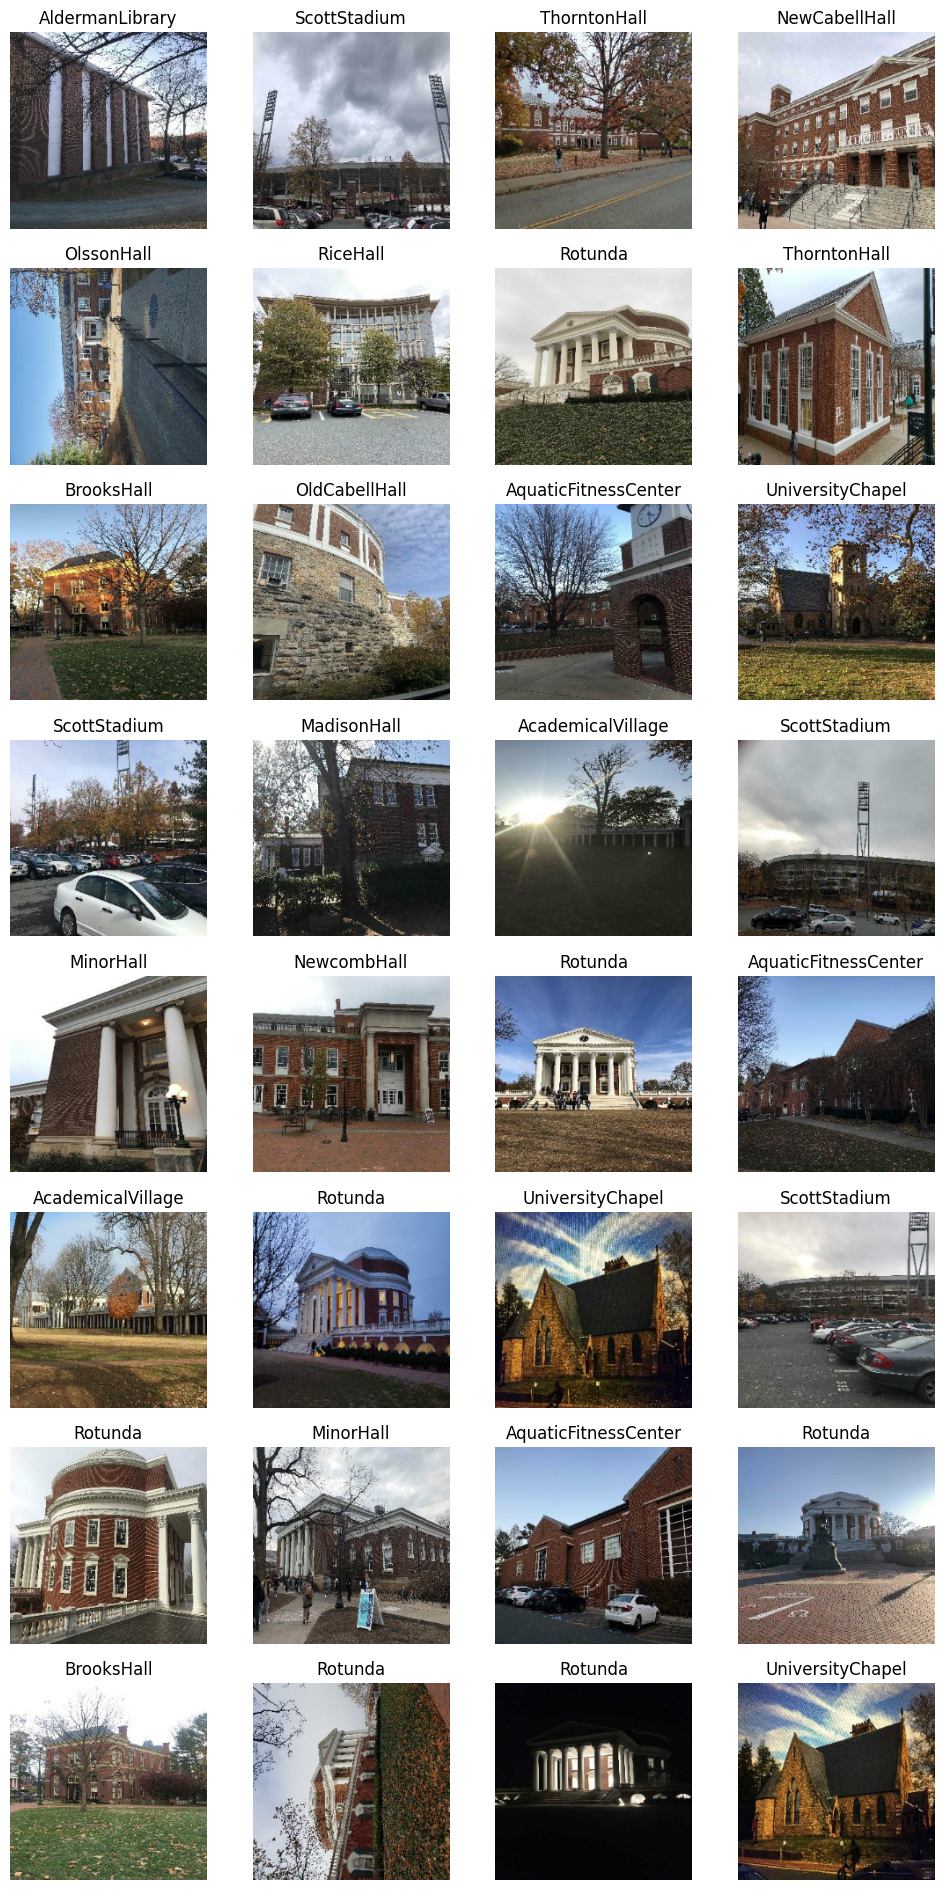

In [10]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter',
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall',
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium',
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


# Step 2: Create your own CNN architecture
You must design your own architecture. To get started, you may get inspiration from one in CNN notebook  (i.e. use one similar to LeNet-5 or AlexNet). You will have to report the design of the architecture:

1.   How many layers does it have?
2.   Why do you decide on a certain number nodes per layer?
3.   Which activation functions do you choose?
4.   How many parameters does it has in total?

Hint: use `myModel.summary()` to learn on the layers and parameters




In [ ]:
# Your code here
'''
# AlexNet Implementation, source: https://en.wikipedia.org/wiki/AlexNet
myModel = keras.models.Sequential([
    keras.layers.Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=[227, 227, 3]),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Conv2D(256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Conv2D(384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),

    keras.layers.Conv2D(384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),

    keras.layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Flatten(),

    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(18, activation='softmax')
                                    ])
'''

# LeNet-5 Implementation, source: https://www.kaggle.com/code/blurredmachine/lenet-architecture-a-complete-guide
myModel = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='tanh', input_shape=[32, 32, 3], padding='same'),
    keras.layers.AveragePooling2D(6, strides=(2,2)),

    keras.layers.Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='tanh', padding='valid'),
    keras.layers.AveragePooling2D(2, strides=(2,2)),

    keras.layers.Conv2D(120, kernel_size=(5,5), strides=(1,1), activation='tanh'),

    keras.layers.Flatten(),

    keras.layers.Dense(84, activation='tanh'),

    keras.layers.Dense(18, activation='softmax')
])


myModel.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │           1,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,686 (244.87 KB)

 Trainable params: 62,686 (244.87 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''
My architecture has 8 layers (not counting an input layer).
The number of nodes per layer was decided based on the design of LeNet-5.
Activation functions were also chosen based on the design of LeNet-5.
Based on the model summary from TensorFlow, the total number of parameters is
62,686.
'''

'\nMy architecture has 14 layers (not counting an input layer).\nThe number of nodes per layer was decided based on the design of AlexNet.\nActivation functions were also chosen based on the design of AlexNet.\nBased on the model summary from TensorFlow, the total number of parameters is\n58,355,090 or about 60 million.\n'

After designing the model, you will need to train it. In order to train, you will need to pick a number of `epoch` (iteration), which `optimizer` to use (from  `keras.optimizers`), a `loss` function, and some `metrics`.

In [ ]:
myEpochs = 10
myOptimizer = "adam"
myLoss = "sparse_categorical_crossentropy"
myMetrics = ["accuracy"]
myModel.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)
history = myModel.fit(train_ds,
                      validation_data = validation_ds,
                      epochs = myEpochs)

Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.1863 - loss: 2.6072 - val_accuracy: 0.2863 - val_loss: 2.3094
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.3221 - loss: 2.2314 - val_accuracy: 0.3623 - val_loss: 2.1080
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.4010 - loss: 2.0054 - val_accuracy: 0.4242 - val_loss: 1.9311
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.4446 - loss: 1.8683 - val_accuracy: 0.4750 - val_loss: 1.7937
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5010 - loss: 1.7012 - val_accuracy: 0.4890 - val_loss: 1.7350
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.5431 - loss: 1.5544 - val_accuracy: 0.5345 - val_loss: 1.6108
Epoch 7/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 43s 66ms/step - accuracy: 0.5839 - loss: 1.4146 - val_accuracy: 0.5516 - val_loss: 1.5488
Epoch 8/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.6087 - loss: 1.3296 - 

Next, you need to create (1) a plot of training and validation `loss` and (2) a plot of training and validation `accuracy`. These plots might give you some insights about your model performance and possibility of overfitting.

Report the performance of your architecture on the validation set in a `confusion matrix`. Make comments on the performance by answering the following questiosns:
- How well do you think your architecture is doing (overall accuracy)?
- Where did it makes mistake most?
- Which classes can be improved?

In [ ]:
# Your evaluation code here

# from CS_4774_14_deep_computer_vision_with_cnns.ipynb
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 10, -0.02, 3])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

def plot_accuracy_curves(accuracy, val_accuracy):
    plt.plot(np.arange(len(accuracy)) + 0.5, accuracy, "b.-", label="Training accuracy")
    plt.plot(np.arange(len(val_accuracy)) + 1, val_accuracy, "r.-", label="Validation accuracy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 10, -0.02, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)

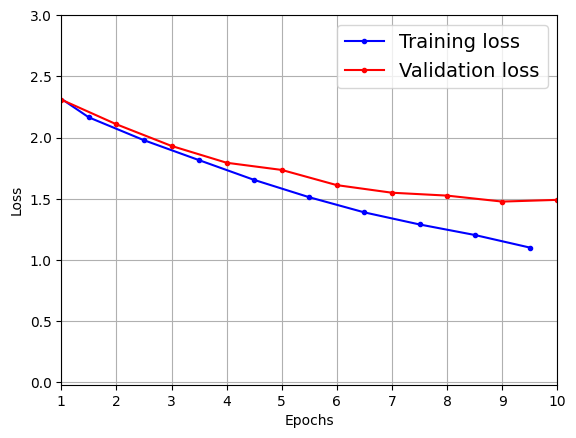

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

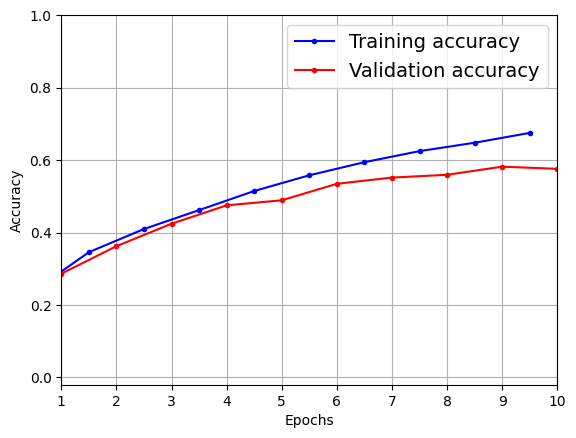

In [ ]:
plot_accuracy_curves(history.history["accuracy"], history.history["val_accuracy"])

In [ ]:
'''
Steady increases in training accuracy but not in validation accuracy suggests overfitting
More epochs would need to be run to confirm this.
'''

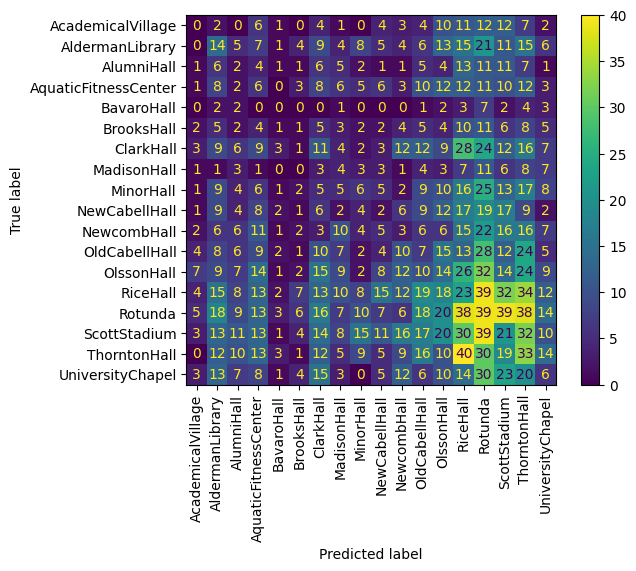

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = np.concatenate([y for x, y in validation_ds], axis=0)
y_pred = np.argmax(myModel.predict(validation_ds), axis=-1)

ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                        display_labels=class_names)
plt.xticks(rotation=90)
plt.show()

In [ ]:
'''
The overall accuracy is relatively poor, meaning the model would need more training
and tuning. From the confusion matrix, we can see that the most mistakes were made
labeling things as the Rotunda and Rice Hall when they weren't. Along with Scott
Stadium and Thornton Hall, these class labels could be improved especially.
'''

# Step 3: Use a Pre-trained Network with Transfer Learning
Now that you have a your own custom model and some baseline performance, let's see if you can improve the performance using transfer learning and a pre-trained model. You may use any pre-trained model EXCEPT ones that already provided such as `Xception`, `MobileNet`, `EfficientNetB6`. Keep in mind that each pre-trained model may expect a different input shape, so adjust the size of your training images accordingly.

Make sure you report the design of this architecture by answer the same questions 1-4 in Step 3.

Hint: use `ImageNet` as weights when load the pre-train network, then add a `GlobalAveragePooling2D` and an output layer with `softmax` activation.



In [5]:
# Your code here

from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model

base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

input = keras.Input(shape=(224, 224, 3))
x = keras.layers.Conv2D(3, (3,3), padding="same")(input)

x = base_model(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(18, activation='softmax')(x)

transfer_learning_model = Model(inputs=input, outputs=output)

transfer_learning_model.summary()

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 7, 7, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │          18,450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,661,638 (82.63 MB)

 Trainable params: 1,330,278 (5.07 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
print(len(base_model.layers))

513


In [ ]:
'''
There are 6 layers in my architecture added on to those present in the pre-trained model.
EfficientNetV2S has 513 layers meaning the total number of layers is 519.
The number of nodes chosen for the custom layers was based on suggestions from
https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/
Activation functions were chosen also based on the previous link as well as personal
experience.
In total there are 21,661,584 parameters, 1,330,224 unfrozen and 20,331,360 frozen
for phase I.
'''

Next, you will attempt to adapt this pre-trained model to your UVA Landmark dataset. It is recommended that you tried the two-phase training approach for your model:

1.   Phase 1: Freeze the pre-train weights and only train the top layer
2.   Phase 2: Train the entire network with much smaller learning rate (adapt the model to UVA data, but avoid destroying the transfered weights).



In [6]:
# Phase 1 code here
transfer_learning_model.compile(loss= "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
history = transfer_learning_model.fit(train_ds,
                      validation_data = validation_ds,
                      epochs = 10)

Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 178s 343ms/step - accuracy: 0.4087 - loss: 1.9793 - val_accuracy: 0.7627 - val_loss: 0.8462
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 121s 213ms/step - accuracy: 0.7256 - loss: 0.9367 - val_accuracy: 0.8180 - val_loss: 0.6596
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 213ms/step - accuracy: 0.7786 - loss: 0.7400 - val_accuracy: 0.8404 - val_loss: 0.5740
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 80s 207ms/step - accuracy: 0.8215 - loss: 0.6136 - val_accuracy: 0.8645 - val_loss: 0.5098
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 208ms/step - accuracy: 0.8543 - loss: 0.5145 - val_accuracy: 0.8708 - val_loss: 0.4985
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 83s 213ms/step - accuracy: 0.8664 - loss: 0.4700 - val_accuracy: 0.8799 - val_loss: 0.4766
Epoch 7/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 213ms/step - accuracy: 0.8794 - loss: 0.4091 - val_accuracy: 0.8764 - val_loss: 0.4824
Epoch 8/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 80s 207ms/step - accuracy: 0.8746 - loss:

In [8]:
# Phase 2 code here
base_model.trainable = True

transfer_learning_model.compile(loss= "sparse_categorical_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=1e-5), metrics = ["accuracy"])
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
history = transfer_learning_model.fit(train_ds,
                      validation_data = validation_ds,
                      epochs = 20,
                      callbacks=[lr_scheduler, keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 387s 646ms/step - accuracy: 0.4941 - loss: 2.5253 - val_accuracy: 0.7021 - val_loss: 1.3262 - learning_rate: 1.0000e-05
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 147s 372ms/step - accuracy: 0.6784 - loss: 1.3238 - val_accuracy: 0.7791 - val_loss: 0.9515 - learning_rate: 1.0000e-05
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 141s 371ms/step - accuracy: 0.7565 - loss: 0.9316 - val_accuracy: 0.8222 - val_loss: 0.7751 - learning_rate: 1.0000e-05
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 142s 370ms/step - accuracy: 0.8100 - loss: 0.7078 - val_accuracy: 0.8474 - val_loss: 0.6691 - learning_rate: 1.0000e-05
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 140s 364ms/step - accuracy: 0.8411 - loss: 0.5670 - val_accuracy: 0.8649 - val_loss: 0.5956 - learning_rate: 1.0000e-05
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 144s 370ms/step - accuracy: 0.8707 - loss: 0.4522 - val_accuracy: 0.8747 - val_loss: 0.5555 - learning_rate: 1.0000e-05
Epoch 7/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 

Repeat the same reporting of performance using the confusion matrix:
- Did this pre-trained network do better overall?
- In which class it improve the accuracy from the above model?
- Which class still has low performance?

Typically, your network must have a reasonable performance of at least 84% overall accuracy to be considered successful in this domain. If your network achieves a accuracy of 94% or above on the validation set, you will also recieve a 10 bonus points, so keep trying!

90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step


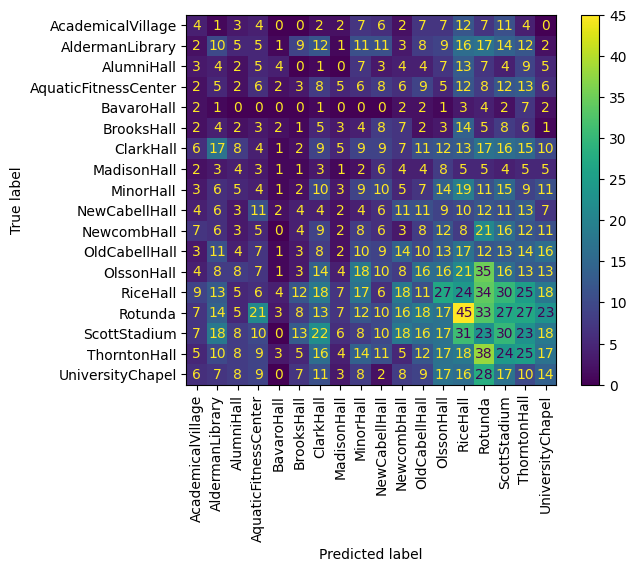

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = np.concatenate([y for x, y in validation_ds], axis=0)
y_pred = np.argmax(transfer_learning_model.predict(validation_ds), axis=-1)

ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                        display_labels=class_names)
plt.xticks(rotation=90)
plt.show()

In [ ]:
'''
The pre-trained network performed much better overall, with a final validation accuracy
of 0.9272 compared to a validation accuracy of 0.5758.
Comparing the confusion matrices, the transfer learning model performed much better
on the Rotunda, ScottStadium, and ThorntonHall images but continued to make
mistakes on RiceHall like the step 2 model.
'''

# Step 4: Reflection

Write at least a paragraph answering these prompts: How did your own network perform in comparison to the pre-trained one? What are the major differences between the architectures? Additionally, report on your experience implementing different models for this assignment (Was it hard/easy/fun?, from which part did you learn the most?)!

In [ ]:
'''
My own network performed much worse than the pre-trained one but that would make sense
because my own network had significantly fewer trainable parameters than the pre-
trained model, even when the pre-trained layers were frozen. Furthermore, the
architecture for my pre-trained model was much more nuanced and complex than that
of the network I implemented, which likely aided in preventing overfitting. My
model also lacked dropout layers which also contribute to preventing overfitting.
I enjoyed implementing these convolutional neural networks and felt that I learned
the most when implementing my own network as I had the most time hands on adding
layers to the architecture. However, I came to a much better understanding as to
what each layer does when I was building my pre-trained model.
'''